#Librerias

In [ ]:
!pip install opencv-python # Instala la librería OpenCV para procesamiento de imágenes
!pip install keras-tuner # Se utiliza para realizar búsqueda automática de hiperparámetros en modelos Keras/TensorFlow.
!pip install --quiet optuna

In [ ]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import keras_tuner as kt

# Librerías para deep learning
import tensorflow as tf
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint ## guardar mejor modelo
from sklearn.metrics import roc_auc_score
import optuna

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays

# Conectar con google drive

In [ ]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [ ]:
import _funciones as fn #Llamar el archivo de funciones de este proyecto

# Carga de datos procesados

array([[[220, 134, 142],
        [218, 131, 147],
        [234, 147, 164],
        ...,
        [232, 153, 167],
        [227, 156, 169],
        [228, 154, 176]],

       [[212, 129, 138],
        [219, 135, 150],
        [231, 147, 163],
        ...,
        [229, 151, 164],
        [227, 156, 171],
        [228, 155, 175]],

       [[208, 127, 135],
        [219, 136, 153],
        [229, 146, 162],
        ...,
        [227, 150, 162],
        [227, 154, 170],
        [230, 157, 176]],

       ...,

       [[211, 137, 150],
        [209, 135, 148],
        [212, 138, 151],
        ...,
        [214, 149, 158],
        [213, 150, 159],
        [206, 144, 153]],

       [[210, 138, 149],
        [210, 139, 150],
        [212, 140, 152],
        ...,
        [215, 149, 159],
        [211, 148, 157],
        [207, 146, 154]],

       [[212, 141, 152],
        [211, 141, 151],
        [213, 141, 152],
        ...,
        [214, 147, 158],
        [211, 148, 157],
        [208, 147, 155]]], dtype=uint8)
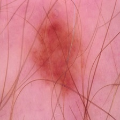

In [ ]:
# Cargar los conjuntos de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [ ]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
x_train.max() # Ver valor máximo
x_train.min() # Ver valor mínimo

np.float32(0.0)

In [ ]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

In [ ]:
# Verificar dimensiones
x_train.shape
x_test.shape

# Número de variables por imagen
np.prod(x_train[1].shape)

# Ver distribución de clases
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1]), array([322, 258]))

In [ ]:
x_train.shape

(2317, 120, 120, 3)

In [ ]:
x_test.shape

(580, 120, 120, 3)

In [ ]:
y_train.shape

(2317, 1)

In [ ]:
y_test.shape

(580, 1)

# Modelo de red convolucional simple

In [ ]:
# Modelo secuencial, capas apiladas una tras otra
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]), #Capa convolucional
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'), #Capa convolucional
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'), #Capa convolucional
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria (0 o 1) con activación sigmoid
])

#Compilar el modelo con  binary cross-entropy y optimizador de Adam
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(
    filepath='Salidas/best_cnn_auc.keras',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)

# Entrenar el modelo
cnn_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), callbacks=checkpoint)

# Resumen del modelo
cnn_model.summary()

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - AUC: 0.5652 - Precision: 0.5262 - Recall: 0.5577 - accuracy: 0.5643 - loss: 0.7436
Epoch 1: val_AUC improved from -inf to 0.83861, saving model to Salidas/best_cnn_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - AUC: 0.5692 - Precision: 0.5289 - Recall: 0.5569 - accuracy: 0.5669 - loss: 0.7401 - val_AUC: 0.8386 - val_Precision: 0.7137 - val_Recall: 0.7248 - val_accuracy: 0.7483 - val_loss: 0.5037
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - AUC: 0.7910 - Precision: 0.6624 - Recall: 0.6323 - accuracy: 0.6979 - loss: 0.5446
Epoch 2: val_AUC improved from 0.83861 to 0.87811, saving model to Salidas/best_cnn_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 625ms/step - AUC: 0.7916 - Precision: 0.6631 - Recall: 0.6347 - accuracy: 0.6987 - loss: 0.5439 - val_AUC: 0.8781 - val_Precision: 0.6384 - val_Recall: 0.9922 - val_accuracy: 0.7466 - val_loss: 0.5694
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - AUC: 0.8438 - Precision

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,832,549 (18.43 MB)

 Trainable params: 1,610,849 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,221,700 (12.29 MB)

In [ ]:
cnn_best_auc=tf.keras.models.load_model('Salidas/best_cnn_auc.keras')
test_loss_m1, test_acc_m1, test_auc_m1, test_recall_m1, test_precision_m1 = cnn_best_auc.evaluate(x_test, y_test, verbose=2)
print("\n### Resultados Red Convolucional Simple maximizando el AUC ###")
print("Test Accuracy:", test_acc_m1)
print("Test AUC:", test_auc_m1)
print("Test Recall:", test_recall_m1)
print("Test Precision:", test_precision_m1)

19/19 - 2s - 124ms/step - AUC: 0.9097 - Precision: 0.7579 - Recall: 0.8372 - accuracy: 0.8086 - loss: 0.3613

### Resultados Red Convolucional Simple maximizando el AUC ###
Test Accuracy: 0.8086206912994385
Test AUC: 0.9097091555595398
Test Recall: 0.8372092843055725
Test Precision: 0.75789475440979


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       322
           1       0.76      0.90      0.82       258

    accuracy                           0.83       580
   macro avg       0.83      0.83      0.83       580
weighted avg       0.84      0.83      0.83       580



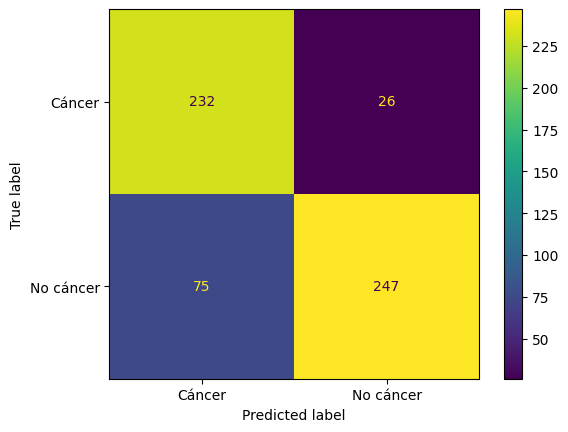

In [ ]:
pred_test = (cnn_best_auc.predict(x_test) > 0.45).astype('int') # Predecir y aplicar umbral de 0.5 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'No cáncer']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

# Modelo convolucional con regularización L2 y Dropout

In [ ]:
reg_strength = 0.2 # Fuerza de regularización
dropout_rate = 0.01  # Tasa de dropout

cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=x_train.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
cnn_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

checkpoint2 = ModelCheckpoint(
    filepath='Salidas/best_cnn2_auc.keras',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)

# Entrenar modelo
cnn_model2.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), callbacks=checkpoint2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - AUC: 0.5421 - Precision: 0.4846 - Recall: 0.2129 - accuracy: 0.5506 - loss: 14.1671
Epoch 1: val_AUC improved from -inf to 0.77026, saving model to Salidas/best_cnn2_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 701ms/step - AUC: 0.5426 - Precision: 0.4845 - Recall: 0.2086 - accuracy: 0.5505 - loss: 13.9605 - val_AUC: 0.7703 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5552 - val_loss: 4.3396
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - AUC: 0.7101 - Precision: 0.6004 - Recall: 0.1111 - accuracy: 0.5774 - loss: 3.7000
Epoch 2: val_AUC did not improve from 0.77026
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 902ms/step - AUC: 0.7102 - Precision: 0.6034 - Recall: 0.1154 - accuracy: 0.5784 - loss: 3.6794 - val_AUC: 0.7663 - val_Precision: 0.6692 - val_Recall: 0.6822 - val_accuracy: 0.7086 - val_loss: 2.2904
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - AUC: 0.7142 - Precision: 0.6552 - Recall: 0.5193 - accuracy:

In [ ]:
cnn2_best_auc=tf.keras.models.load_model('Salidas/best_cnn2_auc.keras')
test_loss_m2, test_acc_m2, test_auc_m2, test_recall_m2, test_precision_m2  = cnn2_best_auc.evaluate(x_test, y_test, verbose=2)

print("\n### Resultados Red Convolucional Con Regularización L2 y Dropout maximizando el AUC ###")
print("Test Accuracy:", test_acc_m2)
print("Test AUC:", test_auc_m2)
print("Test Recall:", test_recall_m2)
print("Test Precision:", test_precision_m2)

19/19 - 2s - 92ms/step - AUC: 0.8394 - Precision: 0.6831 - Recall: 0.9690 - accuracy: 0.7862 - loss: 0.7049

### Resultados Red Convolucional Con Regularización L2 y Dropout maximizando el AUC ###
Test Accuracy: 0.7862069010734558
Test AUC: 0.8394120931625366
Test Recall: 0.9689922332763672
Test Precision: 0.6830601096153259


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
              precision    recall  f1-score   support

           0       0.97      0.58      0.73       322
           1       0.65      0.98      0.78       258

    accuracy                           0.76       580
   macro avg       0.81      0.78      0.76       580
weighted avg       0.83      0.76      0.75       580



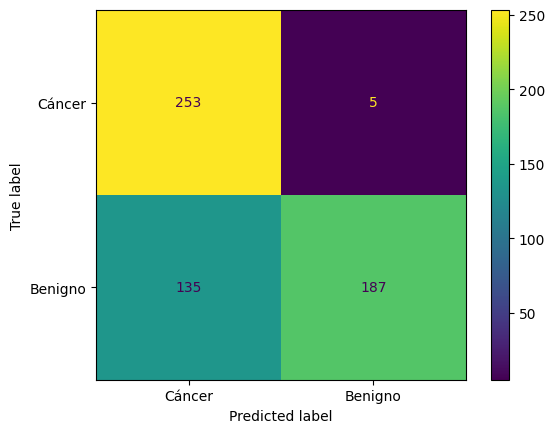

In [ ]:
pred_test = (cnn2_best_auc.predict(x_test) > 0.45).astype('int') # Predecir y aplicar umbral de 0.45 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'Benigno']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

# Afinamiento de hiperparametros

In [ ]:
# Función objetivo para utilizar optuna
def objective(trial):
    # grilla de huiperparámetros
    num_filters = trial.suggest_categorical('num_filters', [32, 64, 128])
    #kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    #dense_units = trial.suggest_categorical('dense_units', [64, 128, 256])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(num_filters*2, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    checkpoint3 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras',
    monitor='auc',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)

    # Choose optimizer
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compile with AUC metric
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Train the model
    history= model.fit(
            x_train, y_train,
            epochs=10,
            validation_data=(x_test, y_test),
            batch_size=100,
            verbose=0,
            callbacks=checkpoint3
        )
    auc = max(history.history['auc'])
    return auc

In [ ]:
# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Carga el mejor modelo GUARDADO en disco (fuera de objective)
best_model_path = '/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras'
best_model = tf.keras.models.load_model(best_model_path)

best_model.summary()

[I 2025-05-29 03:29:07,330] A new study created in memory with name: no-name-0bb95f3f-e3b5-4441-8147-f64aad2a0f91



Epoch 1: auc improved from -inf to 0.60763, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.60763 to 0.80121, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.80121 to 0.81704, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.81704 to 0.85413, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc improved from 0.85413 to 0.87800, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 6: auc improved from 0.87800 to 0.87976, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 7: auc improved from 0.87976 to 0.89367, saving model 

[I 2025-05-29 03:43:33,220] Trial 0 finished with value: 0.9147853851318359 and parameters: {'num_filters': 64, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9147853851318359.



Epoch 1: auc improved from -inf to 0.60974, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.60974 to 0.80608, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.80608 to 0.86351, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.86351 to 0.86423, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc improved from 0.86423 to 0.89299, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 6: auc improved from 0.89299 to 0.90071, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 7: auc improved from 0.90071 to 0.90541, saving model 

In [ ]:
best_model.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras')

modelo_ganador=tf.keras.models.load_model('Salidas/best_cnn_optuna.keras')
test_loss_m3, test_auc_m3 = modelo_ganador.evaluate(x_test, y_test, verbose=2)
print(f"\Mejor AUC on test set: {test_auc_m3:.4f}")

19/19 - 1s - 65ms/step - auc: 0.9123 - loss: 0.3709
\Mejor AUC on test set: 0.9123


In [ ]:
best_params = study.best_trial.params
print("Mejores hiperparámetros:", best_params)


Mejores hiperparámetros: {'num_filters': 128, 'kernel_size': 3, 'dense_units': 64, 'optimizer': 'adam'}


In [ ]:
# Función objetivo para utilizar optuna
def objective(trial):
    # grilla de huiperparámetros
    dropout_rate = hp.Float('DO', 0, 0.5, step=0.05) # Tasa de dropout: 5% a 20%
    reg_strength = hp.Float("rs", 0, 1.05, step=0.01) # Fuerza de regularización L2
    optimizer_name = hp.Choice('optimizer', ['adam', 'sgd']) # Optimizador a usar
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    checkpoint3 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras',
    monitor='auc',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)

    # Choose optimizer
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compile with AUC metric
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Train the model
    history= model.fit(
            x_train, y_train,
            epochs=10,
            validation_data=(x_test, y_test),
            batch_size=100,
            verbose=0,
            callbacks=checkpoint3
        )
    auc = max(history.history['auc'])
    return auc

In [ ]:
# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Carga el mejor modelo GUARDADO en disco (fuera de objective)
best_model_path = '/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras'
best_model = tf.keras.models.load_model(best_model_path)

best_model.summary()

[I 2025-05-29 02:05:37,240] A new study created in memory with name: no-name-d5a00494-6e95-48b0-b4bd-1199ede02b1c
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: auc improved from -inf to 0.55305, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.55305 to 0.69361, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.69361 to 0.77802, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.77802 to 0.78482, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc improved from 0.78482 to 0.85518, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 6: auc improved from 0.85518 to 0.87386, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 7: auc improved from 0.87386 to 0.87770, saving model 

[I 2025-05-29 02:11:58,785] Trial 0 finished with value: 0.9035732746124268 and parameters: {'num_filters': 32, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9035732746124268.



Epoch 1: auc improved from -inf to 0.63489, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.63489 to 0.74161, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.74161 to 0.74265, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.74265 to 0.77141, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc improved from 0.77141 to 0.79887, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 6: auc did not improve from 0.79887

Epoch 7: auc did not improve from 0.79887

Epoch 8: auc did not improve from 0.79887

Epoch 9: auc did not improve from 0.79887

Epoch 10: auc did not improve from 0.79887


[I 2025-05-29 02:15:20,304] Trial 1 finished with value: 0.7988729476928711 and parameters: {'num_filters': 64, 'kernel_size': 3, 'dense_units': 64, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9035732746124268.



Epoch 1: auc improved from -inf to 0.54225, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.54225 to 0.71619, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.71619 to 0.77555, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc did not improve from 0.77555

Epoch 5: auc improved from 0.77555 to 0.78242, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 6: auc did not improve from 0.78242

Epoch 7: auc did not improve from 0.78242

Epoch 8: auc did not improve from 0.78242

Epoch 9: auc did not improve from 0.78242

Epoch 10: auc did not improve from 0.78242


[I 2025-05-29 02:18:32,105] Trial 2 finished with value: 0.7824157476425171 and parameters: {'num_filters': 64, 'kernel_size': 3, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9035732746124268.



Epoch 1: auc improved from -inf to 0.57140, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.57140 to 0.59754, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.59754 to 0.60857, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.60857 to 0.63295, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc improved from 0.63295 to 0.63298, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 6: auc improved from 0.63298 to 0.66995, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 7: auc improved from 0.66995 to 0.70067, saving model 

[I 2025-05-29 02:21:51,526] Trial 3 finished with value: 0.7259063720703125 and parameters: {'num_filters': 64, 'kernel_size': 3, 'dense_units': 64, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9035732746124268.



Epoch 1: auc improved from -inf to 0.70798, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.70798 to 0.85548, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.85548 to 0.88544, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.88544 to 0.88934, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc did not improve from 0.88934

Epoch 6: auc improved from 0.88934 to 0.90223, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 7: auc improved from 0.90223 to 0.90955, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 8: auc impr

[I 2025-05-29 02:25:06,914] Trial 4 finished with value: 0.9223141670227051 and parameters: {'num_filters': 128, 'kernel_size': 3, 'dense_units': 64, 'optimizer': 'adam'}. Best is trial 4 with value: 0.9223141670227051.


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_100 (Conv2D)             │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 59, 59, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 28, 28, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,832,549 (18.43 MB)

 Trainable params: 1,610,849 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,221,700 (12.29 MB)

In [ ]:
best_model.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras')

modelo_ganador=tf.keras.models.load_model('Salidas/best_cnn_optuna.keras')
test_loss_m3, test_auc_m3 = modelo_ganador.evaluate(x_test, y_test, verbose=2)
print(f"\Mejor AUC on test set: {test_auc_m3:.4f}")

19/19 - 1s - 65ms/step - auc: 0.9123 - loss: 0.3709
\Mejor AUC on test set: 0.9123


## Definición del modelo con hiperparámetros para Keras Tuner

In [ ]:
hp = kt.HyperParameters()  # Objeto para definir espacio de búsqueda

def build_model(hp):
    # Hiperparámetros a optimizar
    dropout_rate = hp.Float('DO', 0, 0.5, step=0.05) # Tasa de dropout: 5% a 20%
    reg_strength = hp.Float("rs", 0, 1.05, step=0.01) # Fuerza de regularización L2
    optimizer = hp.Choice('optimizer', ['adam', 'sgd']) # Optimizador a usar

    hp_units_1= hp.Int('units_1', 32, 256, step=16) # Numero de neuronas en la capa densa
    hp_activation_1 = hp.Choice('activation_1', ['relu', 'tanh']) # Función de activación

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation=hp_activation_1, input_shape=x_train.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), # Capa convolucional
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(32, (3, 3), activation=hp_activation_1, kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), # Capa convolucional
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp_units_1, activation=hp_activation_1, kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), # Capa convolucional
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
    ])

    # Selección del optimizador
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)


    # Compilación del modelo con función de pérdida y métrica
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=[
            Recall(name='recall'),
            AUC(name='auc')
        ]
    )

    return model # Retorna el modelo construido con los hiperparámetros definidos

#Resumen de indicadores

In [ ]:
# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    "Modelo": ["CNN Simple", "CNN con regularizador L2 y Dropout", "CNN con afinamiento de hiperparámetros"], # Nombres de los modelos
    "AUC": [test_auc_m1,test_auc_m2,test_auc_m3], # metricas auc de todos los modelos
    "Recall": [test_recall_m1,test_recall_m2,test_recall_m3] #metricas recall de todos los modelos
})

# Mostrar la tabla ordenada por AUC de mayor a menor
resultados = resultados.sort_values(by="AUC", ascending=False)

# Mostrar tabla sin índice
print(tabulate(resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒════════════════════════════════════════╤══════════╤══════════╕
│ Modelo                                 │      AUC │   Recall │
╞════════════════════════════════════════╪══════════╪══════════╡
│ CNN Simple                             │ 0.911358 │ 0.903101 │
├────────────────────────────────────────┼──────────┼──────────┤
│ CNN con regularizador L2 y Dropout     │ 0.847995 │ 0.891473 │
├────────────────────────────────────────┼──────────┼──────────┤
│ CNN con afinamiento de hiperparámetros │ 0.845798 │ 0.434109 │
╘════════════════════════════════════════╧══════════╧══════════╛


En esta segunda tabla se presentan tres variantes de redes neuronales convolucionales (CNN), entrenadas específicamente para procesar imágenes de manchas en la piel, con el objetivo de clasificar si son benignas o malignas. Estas arquitecturas fueron evaluadas con dos métricas fundamentales: AUC y Recall.

El modelo de CNN Simple obtuvo un AUC de 0.9114, el valor más alto entre todos los modelos evaluados, lo que indica una excelente capacidad para diferenciar entre casos de cáncer y casos benignos. Su recall fue de 0.9031, también elevado, lo que refleja una buena capacidad para identificar correctamente los casos positivos.

El modelo de CNN con regularizador L2 y Dropout alcanzó un AUC de 0.8480 y un recall de 0.8915. Aunque su AUC es inferior al del modelo simple, su valor de recall sigue siendo muy alto, lo cual es crucial en contextos médicos, ya que implica una baja tasa de falsos negativos.

Por otro lado, el modelo de CNN con afinamiento de hiperparámetros obtuvo un AUC de 0.8458, el más bajo entre las tres configuraciones, y un recall de solo 0.4341, indicando una capacidad limitada para identificar los casos positivos, lo que reduce significativamente su utilidad clínica.

En comparación con los modelos clásicos evaluados previamente, como Random Forest, Red Neuronal tradicional, Árbol de Decisión, Regresión Logística y KNN, las CNN mostraron un desempeño claramente superior. Por ejemplo, el mejor modelo anterior, Random Forest, alcanzó un AUC de 0.8344 y un recall de 0.8488, valores que fueron superados por las mejores configuraciones de CNN. Aunque los modelos clásicos ofrecen resultados aceptables, su capacidad de discriminación y sensibilidad no se equiparan al rendimiento alcanzado por las redes convolucionales especializadas.

# Exportar el mejor modelo

In [ ]:
# Solo si se necesita
cnn_model.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/skin_cancer_model.h5')  # Guardar modelo entrenado